<a href="https://colab.research.google.com/github/DanielPauliuchenka/SnakeAIGame/blob/main/mura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cjinny/mura-v11")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mura-v11


In [ ]:
# Ячейка 1: Установка (если нужно) и Импорты
# !pip install torch torchvision pandas scikit-learn matplotlib tqdm # Обычно уже есть в Kaggle/Colab

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
from tqdm.notebook import tqdm # для прогресс-баров в jupyter/colab
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Фиксация сидов для воспроизводимости
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Эти настройки могут замедлить обучение, но делают его более детерминированным
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Ячейка 2: Класс MURADataset

class MURADataset(Dataset):
    def __init__(self, csv_file_path, dataset_root_dir, transform=None):
        """
        Args:
            csv_file_path (string): Абсолютный путь к CSV файлу.
                                    (например, '/kaggle/input/mura-v11/MURA-v1.1/train_image_paths.csv')
            dataset_root_dir (string): Абсолютный путь к корневой директории,
                                         содержащей папку MURA-v1.1 (например, '/kaggle/input/mura-v11/').
            transform (callable, optional): Трансформации для изображений.
        """
        self.image_paths_df = pd.read_csv(csv_file_path, header=None, names=['image_path'])
        self.dataset_root_dir = dataset_root_dir
        self.transform = transform

        # Извлечение метки из пути (1 - abnormal/positive, 0 - normal/negative)
        # Пример пути в CSV: MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
        # x.split('/')[-2] будет 'study1_positive' или 'study1_negative'
        self.image_paths_df['label'] = self.image_paths_df['image_path'].apply(
            lambda x: 1 if 'positive' in x.split('/')[-2] else 0
        )

    def __len__(self):
        return len(self.image_paths_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Относительный путь из CSV, например: "MURA-v1.1/train/XR_SHOULDER/..."
        img_relative_path_in_csv = self.image_paths_df.iloc[idx, 0]

        # Собираем полный путь к изображению:
        # dataset_root_dir + img_relative_path_in_csv
        # Например: "/kaggle/input/mura-v11/" + "MURA-v1.1/train/XR_SHOULDER/..."
        # Результат: "/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOULDER/..."
        img_full_path = os.path.join(self.dataset_root_dir, img_relative_path_in_csv)

        try:
            image = Image.open(img_full_path).convert('RGB') # MURA изображения могут быть 1-канальные
        except FileNotFoundError:
            print(f"ОШИБКА: Изображение не найдено по пути {img_full_path}")
            print(f"   Корневая директория датасета была: {self.dataset_root_dir}")
            print(f"   Относительный путь из CSV был: {img_relative_path_in_csv}")
            raise # Прерываем выполнение, если файл не найден

        label = self.image_paths_df.iloc[idx, 1] # Получаем метку из колонки 'label'
        label = torch.tensor(label, dtype=torch.float32) # Для BCEWithLogitsLoss

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Ячейка 3: Пути, Трансформации, Датасеты и Загрузчики Данных

# --- НАСТРОЙКА ПУТЕЙ (СОГЛАСНО ВАШЕМУ СКРИНШОТУ) ---
# Корневая директория, где лежит папка MURA-v1.1 (например, /kaggle/input/mura-v11/)
KAGGLE_DATASET_ROOT = '/kaggle/input/mura-v11/'
# Имя основной папки с данными MURA
MURA_VERSION_SUBFOLDER = 'MURA-v1.1'

# Полный путь к содержимому датасета MURA (где лежат CSV и папки train/valid)
PATH_TO_MURA_DATA_CONTENT = os.path.join(KAGGLE_DATASET_ROOT, MURA_VERSION_SUBFOLDER)

# Пути к CSV файлам
CSV_TRAIN_PATH = os.path.join(PATH_TO_MURA_DATA_CONTENT, 'train_image_paths.csv')
CSV_VAL_PATH = os.path.join(PATH_TO_MURA_DATA_CONTENT, 'valid_image_paths.csv')

# Проверка существования файлов (очень важно!)
if not os.path.exists(KAGGLE_DATASET_ROOT):
    print(f"ОШИБКА: Корневая директория датасета не найдена: {KAGGLE_DATASET_ROOT}")
    raise SystemExit("Ошибка в путях к датасету.")
if not os.path.exists(PATH_TO_MURA_DATA_CONTENT):
    print(f"ОШИБКА: Директория с данными MURA не найдена: {PATH_TO_MURA_DATA_CONTENT}")
    raise SystemExit("Ошибка в путях к датасету.")
if not os.path.exists(CSV_TRAIN_PATH):
    raise FileNotFoundError(f"Train CSV не найден по пути: {CSV_TRAIN_PATH}")
if not os.path.exists(CSV_VAL_PATH):
    raise FileNotFoundError(f"Validation CSV не найден по пути: {CSV_VAL_PATH}")

print(f"Корневая директория Kaggle Dataset: {KAGGLE_DATASET_ROOT}")
print(f"Путь к содержимому MURA: {PATH_TO_MURA_DATA_CONTENT}")
print(f"Путь к Train CSV: {CSV_TRAIN_PATH}")
print(f"Путь к Val CSV: {CSV_VAL_PATH}")
# --- КОНЕЦ НАСТРОЙКИ ПУТЕЙ ---


# Трансформации
IMG_SIZE = 224 # ResNet50 обычно использует 224. Можно пробовать 320 для MURA.
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20), # Увеличим немного диапазон ротации
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05), # Более сильная аугментация цвета
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Стандартные для ImageNet
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Создание датасетов
train_dataset = MURADataset(csv_file_path=CSV_TRAIN_PATH,
                            dataset_root_dir=KAGGLE_DATASET_ROOT,
                            transform=train_transforms)
val_dataset = MURADataset(csv_file_path=CSV_VAL_PATH,
                          dataset_root_dir=KAGGLE_DATASET_ROOT,
                          transform=val_transforms)

# Создание загрузчиков данных
BATCH_SIZE = 64 # Уменьшите, если не хватает GPU памяти (например, 32, 16)
# num_workers > 0 ускоряет загрузку данных, pin_memory=True также может помочь при работе с GPU
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()//2 if os.cpu_count() > 1 else 0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2 if os.cpu_count() > 1 else 0, pin_memory=True)

print(f"\nРазмер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

# Проверка пути к одному из изображений (для отладки)
if len(train_dataset) > 0:
    sample_img_path_from_csv = train_dataset.image_paths_df.iloc[0,0]
    expected_full_path = os.path.join(KAGGLE_DATASET_ROOT, sample_img_path_from_csv)
    print(f"Пример относительного пути из CSV (обучение): {sample_img_path_from_csv}")
    print(f"Ожидаемый полный путь к этому изображению: {expected_full_path}")
    print(f"Метка для этого изображения: {train_dataset.image_paths_df.iloc[0,1]}")
    # Проверим, существует ли файл
    if not os.path.exists(expected_full_path):
        print(f"ПРЕДУПРЕЖДЕНИЕ: Пример файла {expected_full_path} НЕ СУЩЕСТВУЕТ. Проверьте пути!")
    else:
        print(f"Пример файла {expected_full_path} СУЩЕСТВУЕТ. Пути, вероятно, настроены правильно.")

Корневая директория Kaggle Dataset: /kaggle/input/mura-v11/
Путь к содержимому MURA: /kaggle/input/mura-v11/MURA-v1.1
Путь к Train CSV: /kaggle/input/mura-v11/MURA-v1.1/train_image_paths.csv
Путь к Val CSV: /kaggle/input/mura-v11/MURA-v1.1/valid_image_paths.csv

Размер обучающей выборки: 36808
Размер валидационной выборки: 3197
Пример относительного пути из CSV (обучение): MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
Ожидаемый полный путь к этому изображению: /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
Метка для этого изображения: 1
Пример файла /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png СУЩЕСТВУЕТ. Пути, вероятно, настроены правильно.


In [ ]:
# Ячейка 4: Определение Модели (ResNet50)

model = models.resnet50(pretrained=True)

# Заморозка всех слоев, кроме последнего (для начального fine-tuning)
# Можно экспериментировать, размораживая больше слоев позже
# for param in model.parameters():
#    param.requires_grad = False

# Заменяем последний полносвязный слой для бинарной классификации
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5), # Dropout для регуляризации
    nn.Linear(512, 1) # 1 выход, т.к. используем BCEWithLogitsLoss (сигмоида встроена в лосс)
)

model = model.to(device)

# Можно посмотреть, какие параметры будут обучаться
print("Параметры для обучения:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.2MB/s]


Параметры для обучения:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn

In [ ]:
# Ячейка 5: Функция Потерь, Оптимизатор и Планировщик Обучения

# Функция потерь для бинарной классификации
# BCEWithLogitsLoss более численно стабильна, чем Sigmoid + BCELoss
criterion = nn.BCEWithLogitsLoss()

# Оптимизатор (AdamW рекомендуется для трансформеров, но хорошо работает и для CNN)
# Обучаем все параметры, которые не заморожены (requires_grad=True)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

# Планировщик для уменьшения скорости обучения, если метрика перестает улучшаться
# Мы будем следить за val_auc (AUC на валидации). mode='max', т.к. AUC мы хотим максимизировать.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Ячейка 6: Функции для Обучения и Валидации

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train() # Переводим модель в режим обучения
    running_loss = 0.0
    correct_preds_count = 0
    total_samples = 0

    progress_bar = tqdm(loader, desc="Training Epoch", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1) # labels: [B] -> [B,1]

        optimizer.zero_grad() # Обнуляем градиенты
        outputs = model(inputs) # Прямой проход
        loss = criterion(outputs, labels) # Считаем лосс
        loss.backward() # Обратный проход (вычисление градиентов)
        optimizer.step() # Обновляем веса

        running_loss += loss.item() * inputs.size(0)

        # Для расчета точности на лету (accuracy)
        preds_binary = (torch.sigmoid(outputs) > 0.5).long()
        correct_preds_count += (preds_binary == labels).sum().item()
        total_samples += labels.size(0)

        # Обновляем информацию в прогресс-баре
        progress_bar.set_postfix(loss=loss.item(), acc=correct_preds_count/total_samples if total_samples > 0 else 0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds_count / total_samples
    return epoch_loss, epoch_acc


def validate_model(model, loader, criterion, device):
    model.eval() # Переводим модель в режим оценки
    running_loss = 0.0

    all_labels_list = []
    all_probs_list = [] # Для ROC AUC нужны вероятности
    all_preds_binary_list = [] # Для других метрик нужны бинарные предсказания

    progress_bar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad(): # Отключаем вычисление градиентов для валидации
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs) # Получаем вероятности
            preds_binary = (probs > 0.5).long() # Бинарные предсказания по порогу 0.5

            all_labels_list.extend(labels.cpu().numpy())
            all_probs_list.extend(probs.cpu().numpy())
            all_preds_binary_list.extend(preds_binary.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader.dataset)

    # Конвертируем списки в numpy массивы для sklearn
    all_labels_np = np.array(all_labels_list).flatten()
    all_probs_np = np.array(all_probs_list).flatten() # Вероятности для класса "аномалия" (positive class)
    all_preds_binary_np = np.array(all_preds_binary_list).flatten()

    # --- РАСЧЕТ МЕТРИК ---
    # Accuracy (Общая точность)
    epoch_acc = accuracy_score(all_labels_np, all_preds_binary_np)

    # Precision, Recall, F1-score для класса "аномалия" (positive_label=1)
    # average='binary' по умолчанию считает для positive_label=1
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels_np, all_preds_binary_np, average='binary', zero_division=0
    )

    # ROC AUC
    # Убедимся, что есть оба класса в метках, иначе AUC не посчитать корректно
    if len(np.unique(all_labels_np)) < 2:
        epoch_auc = 0.0 # или np.nan
        print("ПРЕДУПРЕЖДЕНИЕ: В валидационной выборке только один класс. AUC не может быть вычислен корректно.")
    else:
        epoch_auc = roc_auc_score(all_labels_np, all_probs_np) # Используем вероятности!

    print(f"\n--- Validation Results ---")
    print(f"Loss: {epoch_loss:.4f}")
    print(f"Accuracy: {epoch_acc:.4f}")
    print(f"AUC: {epoch_auc:.4f}")
    print(f"Precision (for 'abnormal' class): {precision:.4f}")
    print(f"Recall (for 'abnormal' class): {recall:.4f}")
    print(f"F1-score (for 'abnormal' class): {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels_np, all_preds_binary_np)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal (0)', 'Abnormal (1)'], yticklabels=['Normal (0)', 'Abnormal (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return epoch_loss, epoch_acc, epoch_auc, precision, recall, f1


Начало обучения...

Эпоха 1/7, Learning Rate: 1.0e-04
--------------------


Training Epoch:   0%|          | 0/576 [00:00<?, ?it/s]

Результаты эпохи (обучение) -> Loss: 0.4508, Acc: 0.8015


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.4508
Accuracy: 0.8023
AUC: 0.8720
Precision (for 'abnormal' class): 0.8918
Recall (for 'abnormal' class): 0.6680
F1-score (for 'abnormal' class): 0.7638


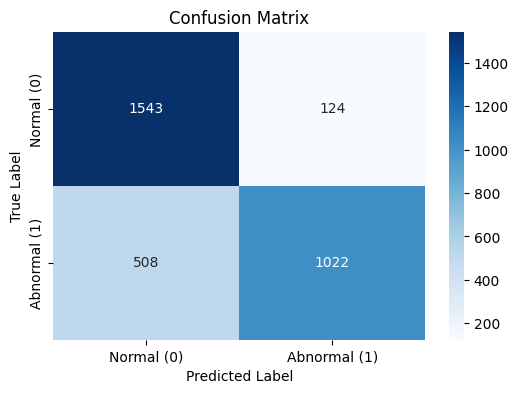

Эпоха 1: Найдена новая лучшая модель с Val AUC: 0.8720. Сохранено в /kaggle/working/mura_resnet50_best.pth

Эпоха 2/7, Learning Rate: 1.0e-04
--------------------


Training Epoch:   0%|          | 0/576 [00:00<?, ?it/s]

Результаты эпохи (обучение) -> Loss: 0.4331, Acc: 0.8131


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.5190
Accuracy: 0.7735
AUC: 0.8671
Precision (for 'abnormal' class): 0.9087
Recall (for 'abnormal' class): 0.5856
F1-score (for 'abnormal' class): 0.7122


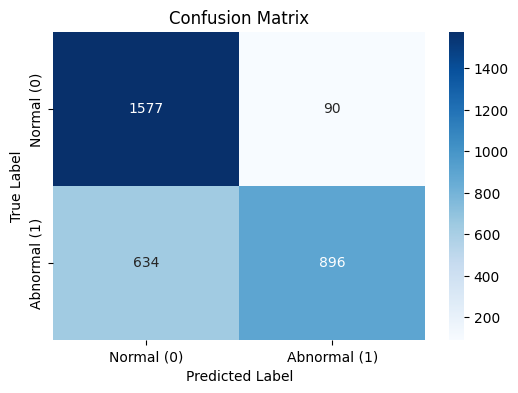


Эпоха 3/7, Learning Rate: 1.0e-04
--------------------


Training Epoch:   0%|          | 0/576 [00:00<?, ?it/s]

Результаты эпохи (обучение) -> Loss: 0.4178, Acc: 0.8204


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.4626
Accuracy: 0.7942
AUC: 0.8646
Precision (for 'abnormal' class): 0.8412
Recall (for 'abnormal' class): 0.7026
F1-score (for 'abnormal' class): 0.7657


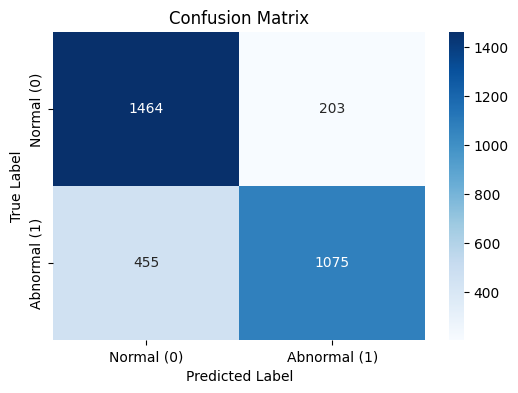


Эпоха 4/7, Learning Rate: 1.0e-04
--------------------


Training Epoch:   0%|          | 0/576 [00:00<?, ?it/s]

Результаты эпохи (обучение) -> Loss: 0.4069, Acc: 0.8288


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.4957
Accuracy: 0.7942
AUC: 0.8664
Precision (for 'abnormal' class): 0.8733
Recall (for 'abnormal' class): 0.6667
F1-score (for 'abnormal' class): 0.7561


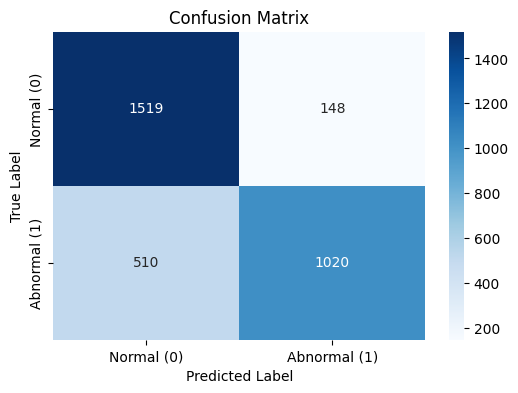


Эпоха 5/7, Learning Rate: 2.0e-05
--------------------


Training Epoch:   0%|          | 0/576 [00:00<?, ?it/s]

Результаты эпохи (обучение) -> Loss: 0.3617, Acc: 0.8507


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.4184
Accuracy: 0.8233
AUC: 0.8908
Precision (for 'abnormal' class): 0.8609
Recall (for 'abnormal' class): 0.7523
F1-score (for 'abnormal' class): 0.8029


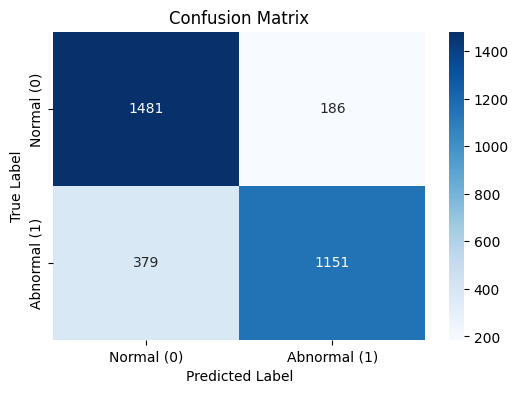

Эпоха 5: Найдена новая лучшая модель с Val AUC: 0.8908. Сохранено в /kaggle/working/mura_resnet50_best.pth

Эпоха 6/7, Learning Rate: 2.0e-05
--------------------


Training Epoch:   0%|          | 0/576 [00:00<?, ?it/s]

Результаты эпохи (обучение) -> Loss: 0.3387, Acc: 0.8611


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.4530
Accuracy: 0.8173
AUC: 0.8829
Precision (for 'abnormal' class): 0.8896
Recall (for 'abnormal' class): 0.7059
F1-score (for 'abnormal' class): 0.7872


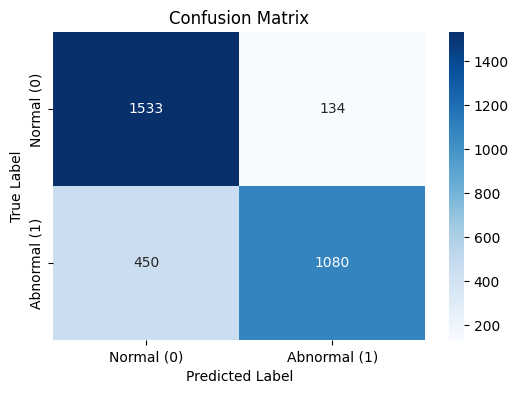


Эпоха 7/7, Learning Rate: 2.0e-05
--------------------


Training Epoch:   0%|          | 0/576 [00:00<?, ?it/s]

Результаты эпохи (обучение) -> Loss: 0.3218, Acc: 0.8690


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.4678
Accuracy: 0.8158
AUC: 0.8827
Precision (for 'abnormal' class): 0.8892
Recall (for 'abnormal' class): 0.7026
F1-score (for 'abnormal' class): 0.7850


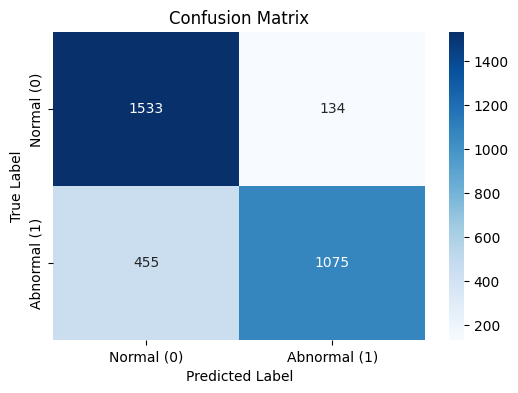


Обучение завершено.
Лучший Validation AUC, достигнутый во время обучения: 0.8908
Лучшая модель сохранена по пути: /kaggle/working/mura_resnet50_best.pth


In [ ]:
# Ячейка 7: Цикл Обучения

NUM_EPOCHS = 7 # Начните с малого (5-10), затем можно увеличить. MURA большой.
best_val_auc = 0.0  # Будем сохранять модель по лучшему AUC
# Или можно выбрать другую метрику, например, best_val_f1 = 0.0

# Путь для сохранения лучшей модели (в Kaggle это /kaggle/working/)
model_save_path = '/kaggle/working/mura_resnet50_best.pth'

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
           'val_auc': [], 'val_precision': [], 'val_recall': [], 'val_f1': [], 'lr': []}

print("\nНачало обучения...")
for epoch in range(NUM_EPOCHS):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nЭпоха {epoch+1}/{NUM_EPOCHS}, Learning Rate: {current_lr:.1e}")
    print("-" * 20)
    history['lr'].append(current_lr)

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Результаты эпохи (обучение) -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    val_loss, val_acc, val_auc, val_precision, val_recall, val_f1 = validate_model(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    # Шаг планировщика по AUC на валидации (mode='max' для AUC)
    scheduler.step(val_auc)

    # Сохранение лучшей модели по AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), model_save_path)
        print(f"Эпоха {epoch+1}: Найдена новая лучшая модель с Val AUC: {best_val_auc:.4f}. Сохранено в {model_save_path}")

print("\nОбучение завершено.")
print(f"Лучший Validation AUC, достигнутый во время обучения: {best_val_auc:.4f}")
if os.path.exists(model_save_path):
    print(f"Лучшая модель сохранена по пути: {model_save_path}")
else:
    print(f"Модель не была сохранена (возможно, обучение было прервано или AUC не улучшался).")


Загрузка лучшей модели из /kaggle/working/mura_resnet50_best.pth для финальной оценки...

Финальная оценка лучшей модели на валидационной выборке:


Validating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Validation Results ---
Loss: 0.4184
Accuracy: 0.8233
AUC: 0.8908
Precision (for 'abnormal' class): 0.8609
Recall (for 'abnormal' class): 0.7523
F1-score (for 'abnormal' class): 0.8029


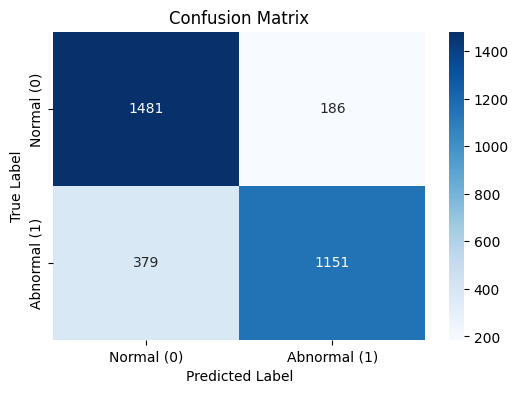

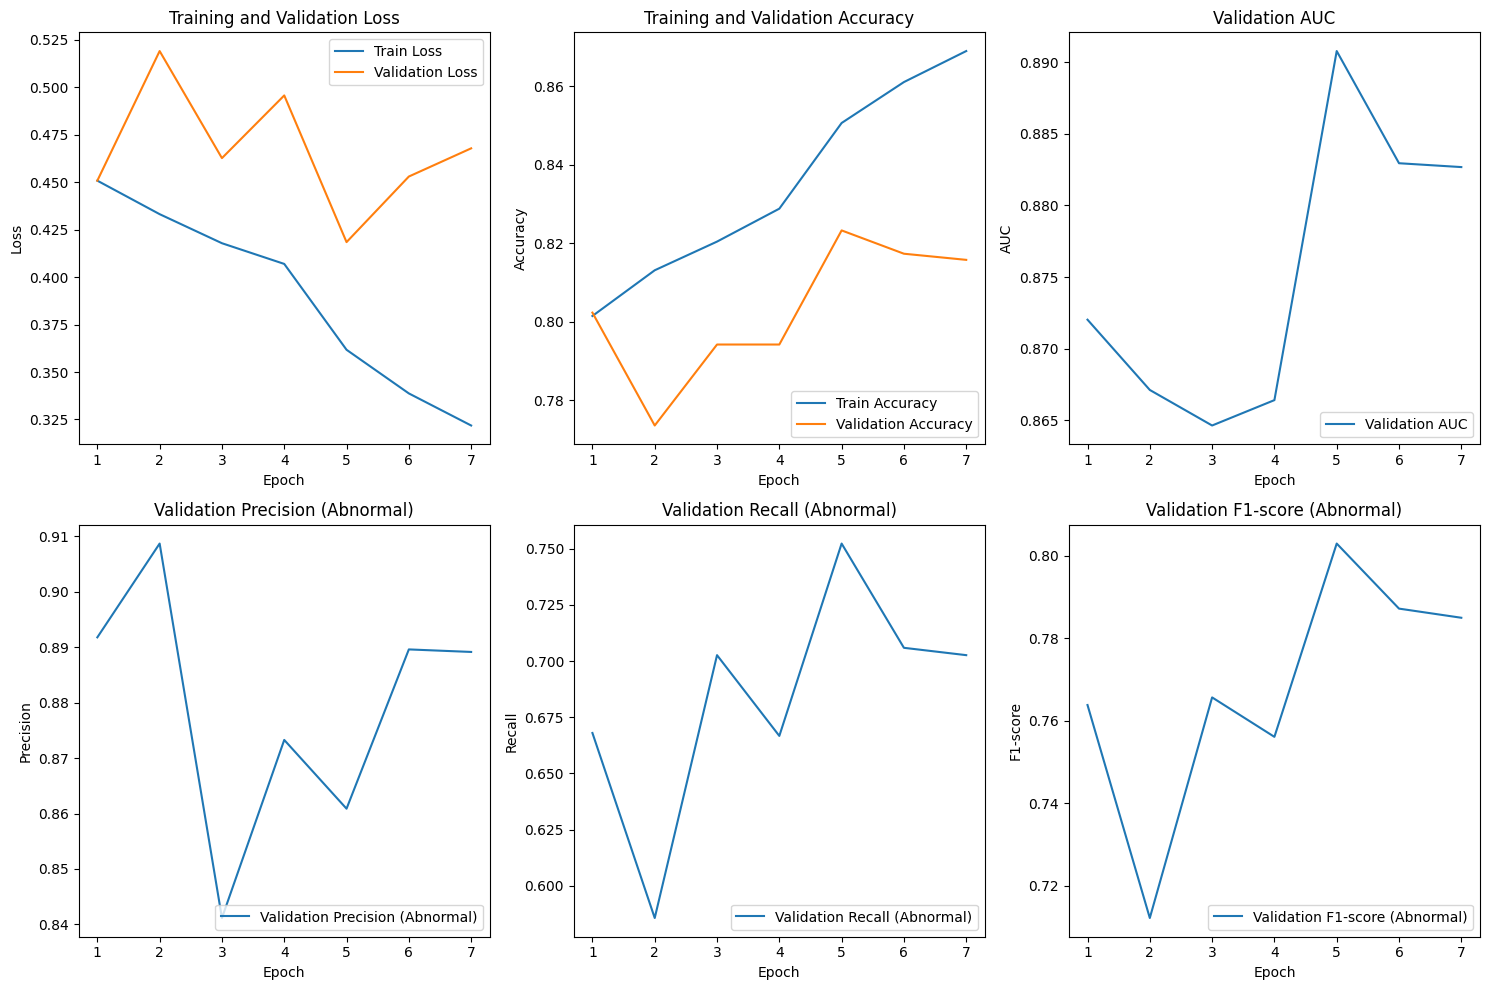

In [ ]:
# Ячейка 8: Загрузка лучшей модели и графики обучения

# Загрузка лучшей модели для финальной оценки (если нужно)
if os.path.exists(model_save_path):
    print(f"\nЗагрузка лучшей модели из {model_save_path} для финальной оценки...")
    model.load_state_dict(torch.load(model_save_path, map_location=device)) # map_location на случай если устройство изменилось

    print("\nФинальная оценка лучшей модели на валидационной выборке:")
    # Повторная валидация с лучшими весами
    _ = validate_model(model, val_loader, criterion, device)
else:
    print("\nФайл лучшей модели не найден. Графики будут построены на основе последней эпохи.")


# Построение графиков обучения
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 3, 3)
plt.plot(epochs_range, history['val_auc'], label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.subplot(2, 3, 4)
plt.plot(epochs_range, history['val_precision'], label='Validation Precision (Abnormal)')
plt.legend(loc='lower right')
plt.title('Validation Precision (Abnormal)')
plt.xlabel('Epoch')
plt.ylabel('Precision')

plt.subplot(2, 3, 5)
plt.plot(epochs_range, history['val_recall'], label='Validation Recall (Abnormal)')
plt.legend(loc='lower right')
plt.title('Validation Recall (Abnormal)')
plt.xlabel('Epoch')
plt.ylabel('Recall')

plt.subplot(2, 3, 6)
plt.plot(epochs_range, history['val_f1'], label='Validation F1-score (Abnormal)')
plt.legend(loc='lower right')
plt.title('Validation F1-score (Abnormal)')
plt.xlabel('Epoch')
plt.ylabel('F1-score')

plt.tight_layout()
plt.show()